In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

from scipy.interpolate import interp1d, make_smoothing_spline

from astropy import units as u

mpl.rc('font', family='serif', size=16)

In [2]:
import jax
import equinox as eqx
from tinygp.helpers import JAXArray

jax.config.update("jax_enable_x64", True)

In [3]:
def dateformat(ax):
    locator   = mpl.dates.AutoDateLocator()
    formatter = mpl.dates.ConciseDateFormatter(locator)
    ax.xaxis.set_major_locator(locator)
    ax.xaxis.set_major_formatter(formatter)

In [4]:
def histogram_residuals(mu_ss, mu_gp, var_ss, var_gp):
    fig, (ax1, ax2) = plt.subplots(1,2,figsize=(8,3), sharey=True)
    ax1.hist(mu_ss-mu_gp)
    ax2.hist(var_ss-var_gp)
    ax1.set(xlabel=r'$\mu_{ss} - \mu_{gp}$', )
    ax2.set(xlabel=r'$\sigma^2_{ss} - \sigma^2_{gp}$');
    fig.tight_layout()
    return fig, (ax1, ax2)

In [5]:
import jax
import jax.numpy as jnp
from jax.scipy.linalg import expm, solve

key = jax.random.PRNGKey(0)

## Import `onefit` to get full GP version of SHO 

In [6]:
import sys
sys.path.insert(0, '/Users/rrubenzahl/Research/Solar/onefit/onefit/')

In [7]:
import importlib
import gpkernels
importlib.reload(gpkernels)
from gpkernels import *

# SHO Kernel in `tinygp` and `ssmolgp`

In [8]:
import tinygp
import smolgp

In [9]:
S=2.36
w=0.0195
Q=7.63
sigma = jnp.sqrt(S*w*Q)

qsSHO = tinygp.kernels.quasisep.SHO(omega=w, quality=Q, sigma=sigma)
ssSHO =smolgp.kernels.SHO(omega=w, quality=Q, sigma=sigma)
gpSHO = gpkernels.OscillationKernel()

Defaulting to solar values.


In [10]:
%%timeit -n 100
qsSHO = tinygp.kernels.quasisep.SHO(omega=w, quality=Q, sigma=sigma)

13.8 μs ± 1.3 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [11]:
%%timeit -n 100
ssSHO =smolgp.kernels.SHO(omega=w, quality=Q, sigma=sigma)

15.7 μs ± 864 ns per loop (mean ± std. dev. of 7 runs, 100 loops each)


# Use tinygp to define a 'ground truth' process

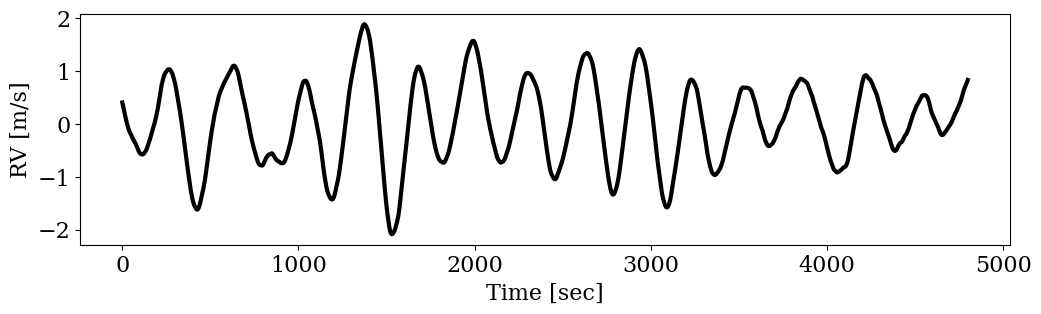

In [12]:
def get_true_gp(tmax, tunit='s', dt=1):
    t = u.Quantity(jnp.arange(0, tmax, dt), tunit).to('s').value
    true_gp = tinygp.GaussianProcess(qsSHO, t)
    # gp.sample adds small random noise for numerical stability
    y_sample = true_gp.sample(key=jax.random.PRNGKey(32)) 
    f = make_smoothing_spline(t, y_sample, lam=10/60)
    return t, f

baseline_minutes = 80
t, f = get_true_gp(baseline_minutes, 'min', dt=1/60)
fig, ax = plt.subplots(1,1,figsize=(12,3))
ax.plot(t, f(t), label='Example SHO', color='k', lw=3)
ax.set(ylabel='RV [m/s]', xlabel=f'Time [sec]');

## Make synthetic observations

In [13]:
#### Simulated dataset
def generate_data(N, yerr=0.3, tmin=None, tmax=None, baseline_minutes=80):

    # Generate true GP over baseline
    t, f = get_true_gp(baseline_minutes, 'min', dt=1/60)
    tmin = t.min() if tmin is None else tmin
    tmax = t.max() if tmax is None else tmax

    # Generate synthetic observations (no exposure time)
    t_train = jnp.linspace(tmin, tmax, N+2)[1:-1]
    y_true = f(t_train)
    y_train = y_true + yerr * jax.random.normal(key, shape=(N,))
    return t_train, y_train

In [14]:
np.random.seed(231)

N = 30
yerr = 0.3 # m/s
t_train, y_train = generate_data(N, yerr)

i,di=10,5
delete = jnp.arange(i,i+di,1)
t_train = jnp.delete(t_train, delete)
y_train = jnp.delete(y_train, delete)

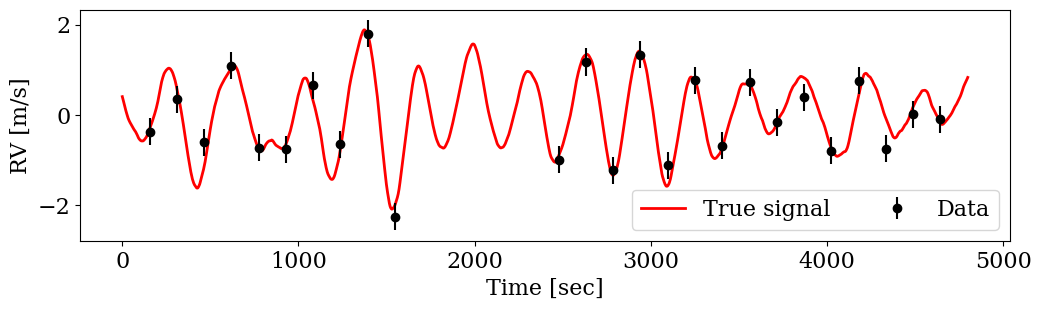

In [15]:
fig, ax = plt.subplots(1,1,figsize=(12,3))

ax.plot(t, f(t), label='True signal', color='r', lw=2)
ax.errorbar(t_train, y_train, yerr, fmt='o', color='k', label='Data')

ax.legend(ncol=2)
ax.set(ylabel='RV [m/s]', xlabel=f'Time [sec]');

In [16]:
def sample_data(N, yerr=0.3):
    return generate_data(N, qsSHO, yerr=yerr)

In [17]:
t_test = jnp.linspace(t.min(), t.max(), 1000)

# Multi-component model

1. build with tinygp, build with smolgp

2. show they give the same likelihood

3. show they give the same conditioned/predictive mean/var

4. test mixture of integrated and regular kernel

## 1a. Build with `ssmolgp`

In [18]:
ssm1 = smolgp.kernels.SHO(omega=w, quality=Q, sigma=sigma)
ssm2 = smolgp.kernels.SHO(omega=0.00234587265, 
                           quality=1/jnp.sqrt(2), 
                           sigma=0.329)
ssm = ssm1 + ssm2
# ssm = ssm1 * ssm2
ssm

Sum(
  dimension=4,
  kernel1=SHO(omega=0.0195, quality=7.63, sigma=weak_f64[], eta=weak_f64[]),
  kernel2=SHO(
    omega=0.00234587265, quality=weak_f64[], sigma=0.329, eta=weak_f64[]
  )
)

## 1b. Build with `tinygp`

In [19]:
kernel1 = tinygp.kernels.quasisep.SHO(omega=w, quality=Q, sigma=sigma)
kernel2 = tinygp.kernels.quasisep.SHO(omega=0.00234587265, 
                                      quality=1/jnp.sqrt(2), 
                                      sigma=0.329)
kernel = kernel1 + kernel2
# kernel = kernel1 * kernel2
kernel

Sum(
  kernel1=SHO(omega=0.0195, quality=7.63, sigma=weak_f64[]),
  kernel2=SHO(omega=0.00234587265, quality=weak_f64[], sigma=0.329)
)

In [20]:
gp_ss=smolgp.GaussianProcess(kernel=ssm, X=t_train, diag=yerr**2)
gp_qs= tinygp.GaussianProcess(kernel=kernel, X=t_train, diag=yerr**2)

## 2. Likelihoods verification

In [21]:
gp_qs.log_probability(y_train)

Array(-25.41990952, dtype=float64)

In [22]:
gp_ss.log_probability(y_train)

Array(-25.41990952, dtype=float64)

In [23]:
gp_qs.log_probability(y_train) - gp_ss.log_probability(y_train)

Array(-7.10542736e-15, dtype=float64)

## 3a. Condition verification

In [24]:
## Throws an error if X_test is not given (TODO: open issue in tinygp)
condGP_qs = gp_qs.condition(y_train, t_train).gp
llh, condGP_ss = gp_ss.condition(y_train)

# ## also going to have to do a check w/ to_dense in SSM predict
# condGP2.predict(t_test, return_var=True)

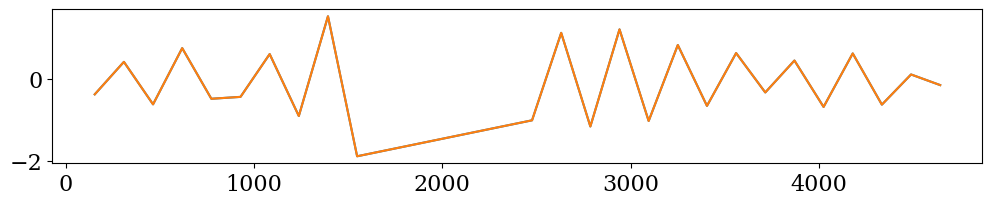

In [25]:
plt.figure(figsize=(12,2))
plt.plot(t_train, condGP_qs.loc)
plt.plot(t_train, condGP_ss.loc)

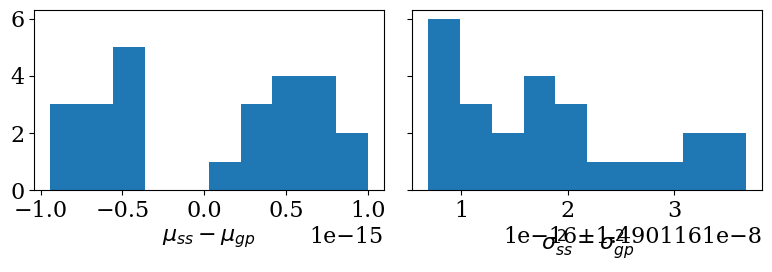

In [26]:
fig, (ax1, ax2) = histogram_residuals(condGP_qs.loc, condGP_ss.loc,
                                      condGP_qs.variance, condGP_ss.variance)

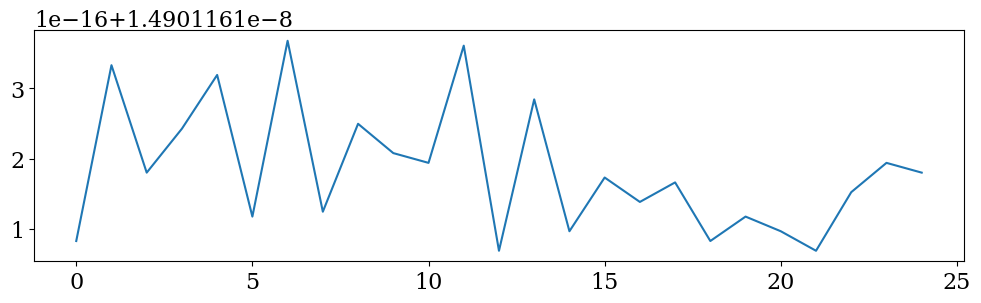

In [27]:
plt.figure(figsize=(12,3))
plt.plot(condGP_qs.variance-condGP_ss.variance)

In [28]:
# gp_qs.predict(y_train) # throws an error if X_test is not given

# The problem is with this line, 
# something to do with `a` which comes from p, q, a = self.lower
# gp_qs.solver.factor.inv()

## 3b. Prediction verification

In [29]:
mu_qs, var_qs = gp_qs.predict(y_train, t_test, return_var=True)

In [30]:
# mu_ss, var_ss = condGP_ss.predict(t_train, return_var=True)
mu_ss, var_ss = gp_ss.predict(t_test, y_train, return_var=True)

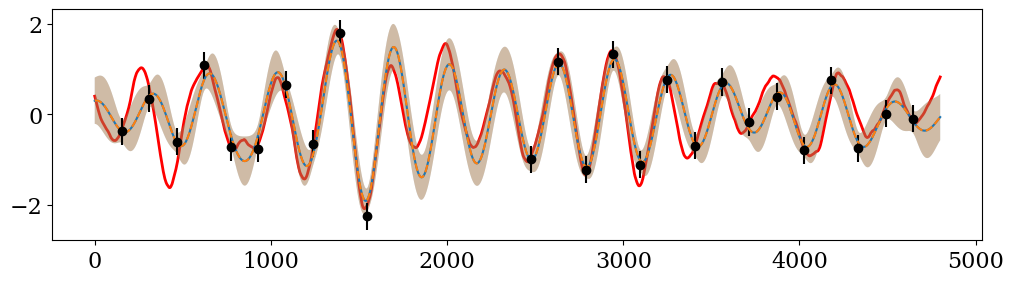

In [31]:
plt.figure(figsize=(12,3))

plt.plot(t, f(t), label='True signal', color='r', lw=2, zorder=-10)
plt.errorbar(t_train, y_train, yerr, fmt='o', color='k', label='Data', alpha=1)

plt.plot(t_test, mu_qs)
plt.fill_between(t_test, mu_qs-jnp.sqrt(var_qs), mu_qs+jnp.sqrt(var_qs), alpha=0.3)

plt.plot(t_test, mu_ss, ls='--')
plt.fill_between(t_test, mu_ss-jnp.sqrt(var_ss), mu_ss+jnp.sqrt(var_ss), alpha=0.3)

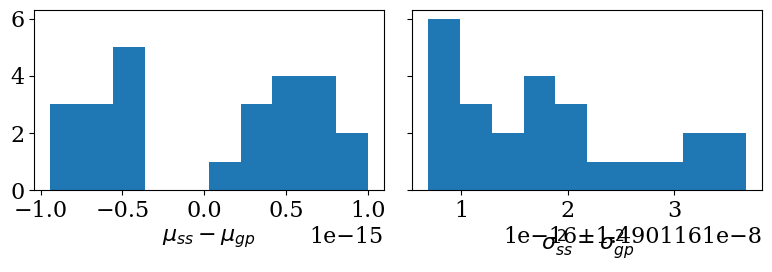

In [32]:
fig, (ax1, ax2) = histogram_residuals(condGP_qs.loc, condGP_ss.loc,
                                      condGP_qs.variance, condGP_ss.variance)

## Predict at a single component kernel

In [33]:
# diag = yerr**2 

# shokern = tinygp.kernels.quasisep.SHO(omega=w, quality=Q, sigma=sigma)
# gp = tinygp.GaussianProcess(shokern, t_train, diag=diag)
# y_gp, yvar_gp = gp.predict(y_train, t_train, kernel=shokern, return_var=True)
# mu_gp, var_gp = gp.predict(y_train, t_test,  kernel=shokern, return_var=True)
# yerr_gp = jnp.sqrt(yvar_gp)
# std_gp  = jnp.sqrt(var_gp)

In [34]:
y_ss = condGP_ss.loc
y_gp = condGP_qs.loc
yerr_ss = jnp.sqrt(condGP_ss.variance)
yerr_gp = jnp.sqrt(condGP_qs.variance)

mu_gp = mu_qs
std_gp = jnp.sqrt(var_qs)
std_ss = jnp.sqrt(var_ss)

### Plot

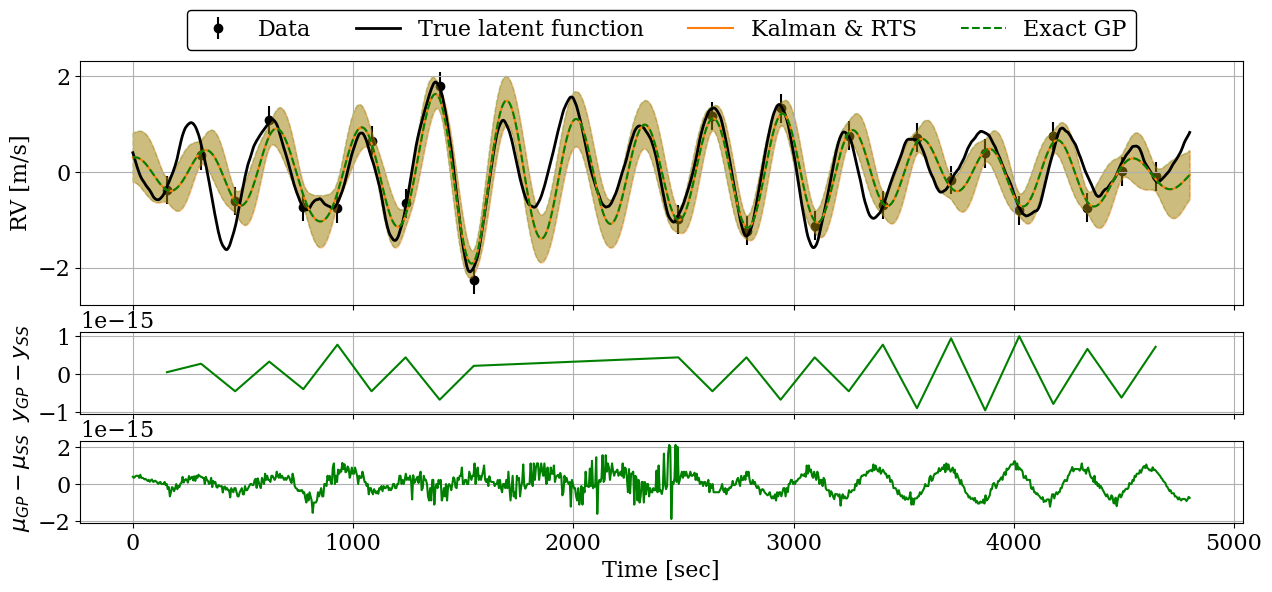

In [35]:
fig, (ax, rax1, rax2) = plt.subplots(3,1, figsize=(15, 6), sharex=True, gridspec_kw={'height_ratios':[3,1,1]})

cobs = 'k' # 'w'
ctrue = 'k'
cgp  = 'g'
ckal = 'C0'
crts = 'C1'

## Data and true signal
l1 = ax.errorbar(t_train, y_train, yerr, fmt='o', zorder=0, color=cobs, label="Data")
l2, = ax.plot(t, f(t), color=ctrue, lw=2, label="True latent function")

## Kalman filtered result
# l3, = ax.plot(t_train, y_kal, 'o', color=ckal,  ls=':',  label="Kalman Filtered Mean")
# ax.fill_between(t_train, y_kal-yerr_kal, y_kal+yerr_kal, color=ckal, alpha=0.2)

# ## RTS smoothed result
# l4, = ax.plot(t_train, y_ss, 'o', color=crts,  ls='-', label="RTS Smoothed Mean")
# ax.fill_between(t_train, y_ss-yerr_ss, y_ss+yerr_ss, color=crts, alpha=0.2)

# ## GP solution
# l5, = ax.plot(t_train, y_gp, 'o', color=cgp,   ls='-',  label="Exact GP Mean")
# ax.fill_between(t_train, y_gp-yerr_gp, y_gp+yerr_gp, color=cgp, alpha=0.2)

## Test predictions
l4, = ax.plot(t_test, mu_ss, color=crts,  ls='-', label="Kalman & RTS")
ax.fill_between(t_test, mu_ss-std_ss, mu_ss+std_ss, ls='-', color=crts, alpha=0.4)

l5, = ax.plot(t_test, mu_gp,  color=cgp,   ls='--',  label="Exact GP")
ax.fill_between(t_test, mu_gp-std_gp, mu_gp+std_gp, ls='--', color=cgp, alpha=0.2)

lines = [l1, l2, l4, l5]
ax.legend(lines, [l.get_label() for l in lines],
            ncol=4,# loc='upper center', #fontsize=14,
            loc='lower center', bbox_to_anchor=[0.5,1],
              framealpha=1, edgecolor='k', 
            # facecolor='#232323' 
            )
# ax.set_title("State-Space GP vs. Exact GP")
ax.set(ylabel='RV [m/s]', )#xlim=[max(t_test.min(), t.min().to(kernel.tunit).value),
                        #  min(t_test.max(), t.max().to(kernel.tunit).value)])
# ax.set_ylim(f(t).min()-.2, f(t).max()+1)
ax.grid()

# rax.plot(t_train, y_kal-y_true, ckal, ls=':')
rax1.plot(t_train, y_gp-y_ss,  cgp , ls='-')
# rax1.plot(t_train, )

mu_true = f(t_test/60)
rax2.plot(t_test, mu_gp-mu_ss, c=cgp , ls='-')
# rax2.fill_between(t_test, (mu_ss-std_ss) - (mu_gp-std_gp), 
#                           (mu_ss+std_ss) - (mu_gp+std_gp), 
#                   ls='--', color='k', alpha=0.2)

rax1.set(ylabel=r'$y_{GP}-y_{SS}$')
rax2.set(xlabel='Time [sec]', ylabel=r'$\mu_{GP}-\mu_{SS}$')

rax1.grid();rax2.grid();

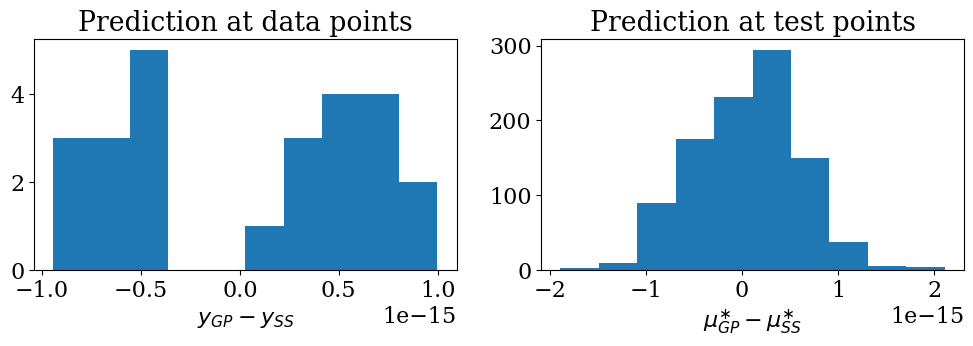

In [36]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(12, 3))
ax1.hist(y_gp - y_ss);
# ax1.hist(yvar_gp - yvar_ss);
ax1.set(title='Prediction at data points', xlabel='$y_{GP} - y_{SS}$')

ax2.hist(mu_gp - mu_ss);
# ax2.hist(var_gp - var_ss);
ax2.set(title='Prediction at test points', xlabel=r'$\mu^{\ast}_{GP} - \mu^{\ast}_{SS}$');

# Integrated version tests

In [37]:
from smolgp.helpers import Phibar_from_VanLoan

## Augmented matrices

In [38]:
isho = smolgp.kernels.integrated.IntegratedSHO(omega=w, quality=Q, sigma=sigma, num_insts=1)

F_aug = isho.design_matrix()
L_aug = isho.noise_effect_matrix()
A_aug = lambda dt: isho.transition_matrix(0, dt)
Q_aug = lambda dt: isho.process_noise(0, dt)
Reset_matrix = isho.reset_matrix

print(isho.dimension, ':', L_aug.shape, F_aug.shape, A_aug(3).shape, Q_aug(3).shape, Reset_matrix(0).shape)

4 : (4, 1) (4, 4) (4, 4) (4, 4) (4, 4)


## Test the analytic and numerical integrated transition matrix are the same

In [39]:
# "Default" instantation of integrated SHO
sho = smolgp.kernels.SHO(omega=w, quality=Q, sigma=sigma)
idef = smolgp.kernels.integrated.IntegratedStateSpaceModel(base_model=sho, num_insts=1)
vanloan  = lambda dt: idef.integrated_transition_matrix(0, dt)

# Analytic version from above
analytic = lambda dt: isho.integrated_transition_matrix(0, dt)

## Compare
dts = jnp.linspace(0, 100, 1000)
jnp.all(jax.vmap(lambda dt: jnp.allclose(analytic(dt), vanloan(dt)))(dts))

Array(True, dtype=bool)

## Integrated GP from `smolgp` vs. `tinygp` using Luhn et al. method

### New simulated dataset for testing the integrated verison

In [67]:
Ninst = 2

# tmin = t.min()
# tmax = t.max()
tmin = 0.0
tmax = 1800
print(tmin, tmax)

0.0 1800


In [68]:
def make_exposure(tmid, texp):
    t_in_exp = jnp.linspace(tmid-texp/2, tmid+texp/2, 100)
    return jnp.mean(f(t_in_exp))

#### Simulated dataset
np.random.seed(231)
if Ninst==1:
    yerr = 0.3 # m/s
    texp = 180. # sec
    readout = 40 # sec
    cadence = texp + readout
    t_train = jnp.arange(tmin+texp, tmax-texp, cadence)
    N = len(t_train)
    texp_train = jnp.full(N, texp)  # constant exposure time for all observations
    yerr_train = jnp.full(N, yerr)  # constant uncertainty for all observations
    instids = jnp.zeros(N, dtype=int)
elif Ninst==2:
    ### TWO INSTRUMENTS
    texp1 =  60.; texp2 = 180. # sec
    yerr1 =  0.3; yerr2 = 0.3  # m/s
    rout1 =  28.; rout2 = 40.  # sec
    # rout1 =  0; rout2 = 0  # sec
    cadence1 = texp1 + rout1; cadence2 = texp2 + rout2
    times1 = jnp.arange(tmin+texp1, tmax-texp1, cadence1)  # uniformly sample N points
    times2 = jnp.arange(tmin+texp2, tmax-texp2, cadence2)  # uniformly sample N points
    N1 = len(times1); N2 = len(times2);
    t_train = jnp.hstack([times1, times2])
    instids = jnp.hstack([jnp.zeros(N1, dtype=int), jnp.ones(N2, dtype=int)]) # which instrument recorded each obs
    texp_train = jnp.hstack([jnp.full(N1, texp1), jnp.full(N2, texp2)]) # exposure time for each obs
    yerr_train = jnp.hstack([jnp.full(N1, yerr1), jnp.full(N2, yerr2)]) # uncertainty for each obs
    sortidx = jnp.argsort(t_train)
    t_train    = t_train[sortidx]
    instids    = instids[sortidx]
    texp_train = texp_train[sortidx]
    yerr_train = yerr_train[sortidx]
else:
    raise NotImplementedError("Only Ninst=1 or 2 simulated datasets implemented")

###### Generate synthetic measurements
y_inst = f(t_train)
y_true = jnp.array([make_exposure(t_train[n], texp_train[n]) for n in range(len(t_train))])
y_train = y_true + yerr * jax.random.normal(key, shape=(len(t_train),))
N = len(t_train)
R = jnp.square(yerr_train)

In [69]:
## True process
t_true = jnp.linspace(tmin, tmax, 1000)
y_true = f(t_true)

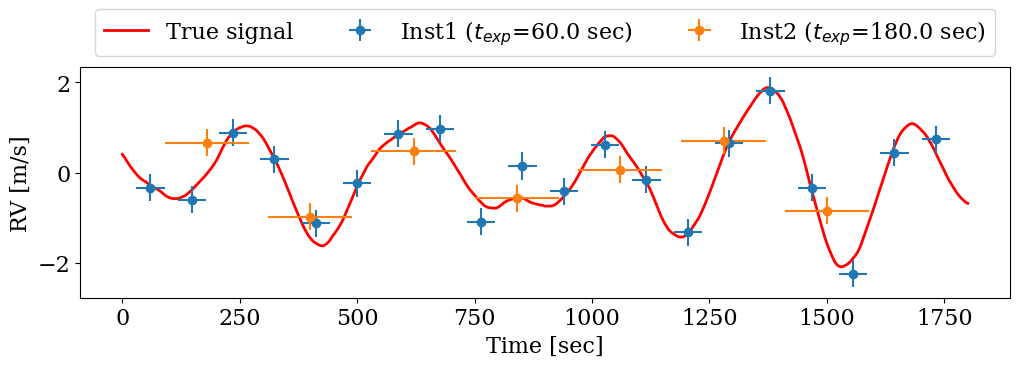

In [70]:
fig, ax = plt.subplots(1,1,figsize=(12,3))

ax.plot(t_true, y_true, label='True signal', color='r', lw=2)
# ax.errorbar(tobs.value, y_inst,  yerr=yerr, fmt='o', color='grey')
# ax.errorbar(tobs.value, y_train, xerr=texp/60/2, yerr=yerr, fmt='o', color='k', label=r'$t_{exp}$=' + f'{texp} sec')
for instid in range(Ninst):
    inst = (instids==instid)
    ax.errorbar(t_train[inst], y_train[inst], xerr=texp_train[inst]/2, yerr=yerr,
                 fmt='o', label=f'Inst{instid+1} ($t_{{exp}}$={texp_train[inst][0]} sec)')

ax.legend(ncol=3, bbox_to_anchor=[0.5,1], loc='lower center')
ax.set(ylabel='RV [m/s]', xlabel=f'Time [sec]');

In [71]:
tmid = t_train # exposure midpoints

## Construct interleaved time array for integrated Kalman/RTS
ts = tmid - texp_train/2  # Exposure start times
te = tmid + texp_train/2  # Exposure end times
obsid = jnp.arange(len(tmid)).repeat(2)  # which observation does each time belong to

# Interleave start and end times into one array (fastest)
# https://stackoverflow.com/questions/5347065/interleaving-two-numpy-arrays-efficiently
t_states = jnp.empty((ts.size + te.size,), dtype=tmid.dtype)
t_states = t_states.at[0::2].set(ts)  # evens are start times
t_states = t_states.at[1::2].set(te)  # odds are end times
# Have to re-sort because exposures can overlap
sortidx  = jnp.argsort(t_states)
t_states = t_states[sortidx]
obsid    = obsid[sortidx] 
stateids = jnp.tile(jnp.array([0,1]), len(tmid))[sortidx] # 0 for t_s, 1 for t_e

In [72]:
print('k   t[s]    obs  inst  state')
print('----------------------------')
for k in range(len(t_states)):
    print(f'{k:<2d}  {t_states[k]:<7.1f}  {obsid[k]:<2}   {instids[obsid[k]]}   {stateids[k]}')
    if k>8:
        break

k   t[s]    obs  inst  state
----------------------------
0   30.0     0    0   0
1   90.0     0    0   1
2   90.0     2    1   0
3   118.0    1    0   0
4   178.0    1    0   1
5   206.0    3    0   0
6   266.0    3    0   1
7   270.0    2    1   1
8   294.0    4    0   0
9   310.0    5    1   0


## Run integrated solver

In [73]:
isho_ss = smolgp.kernels.integrated.IntegratedSHO(omega=w, quality=Q, sigma=sigma, num_insts=Ninst)
isho_gp = gpkernels.IntegratedOscillationKernel()

Defaulting to solar values.


In [74]:
igp_ss = smolgp.GaussianProcess(kernel=isho_ss, 
          X=(t_train, texp_train, instids), diag=R)

In [75]:
igp_gp = tinygp.GaussianProcess(kernel=isho_gp, 
          X=(t_train, instids, texp_train), diag=R)

In [76]:
# a,b,c,d, v,S = igp_ss.solver.Kalman(y_train, return_v_S=True)

## Likelihood

In [77]:
llh_ss = igp_ss.log_probability(y_train)
llh_gp = igp_gp.log_probability(y_train)

llh_ss - llh_gp

Array(-1.42108547e-14, dtype=float64)

## Condition

In [78]:
condGP_gp = igp_gp.condition(y_train, X_test=(t_train, instids, 
                                              texp_train)).gp

In [79]:
llh, condGP_ss = igp_ss.condition(y_train)
llh

Array(-27.64429528, dtype=float64)

In [80]:
(condGP_gp.mean-condGP_ss.mean)

Array([-1.33226763e-15, -3.33066907e-16,  2.60902411e-15,  1.33226763e-15,
       -2.83106871e-15, -9.99200722e-16,  0.00000000e+00,  4.05231404e-15,
        3.21964677e-15, -1.77635684e-15, -5.71764858e-15, -1.77635684e-15,
        1.16573418e-15, -5.55111512e-17,  5.63438185e-15, -4.44089210e-16,
       -4.19109192e-15, -8.46545056e-15,  6.66133815e-16,  1.11022302e-15,
        2.55351296e-15, -1.11022302e-15, -2.38697950e-15,  0.00000000e+00,
        1.77635684e-15, -8.32667268e-16,  1.11022302e-16], dtype=float64)

In [81]:
(condGP_gp.variance-condGP_ss.variance)

Array([1.49011554e-08, 1.49011635e-08, 1.49011621e-08, 1.49011725e-08,
       1.49011602e-08, 1.49011607e-08, 1.49011600e-08, 1.49011549e-08,
       1.49011613e-08, 1.49011574e-08, 1.49011362e-08, 1.49011598e-08,
       1.49011607e-08, 1.49011602e-08, 1.49011561e-08, 1.49011614e-08,
       1.49011597e-08, 1.49011554e-08, 1.49011608e-08, 1.49011609e-08,
       1.49011604e-08, 1.49011602e-08, 1.49011611e-08, 1.49011612e-08,
       1.49011610e-08, 1.49011612e-08, 1.49011613e-08], dtype=float64)

In [82]:
## Unpack conditioned states
m_predicted_int = condGP_ss.states.predicted_mean
m_filtered_int  = condGP_ss.states.filtered_mean
m_smooth_int    = condGP_ss.states.smoothed_mean
P_predicted_int = condGP_ss.states.predicted_var
P_filtered_int  = condGP_ss.states.filtered_var
P_smooth_int    = condGP_ss.states.smoothed_var
print(m_predicted_int.shape, m_filtered_int.shape, m_smooth_int.shape)
print(P_predicted_int.shape,P_filtered_int.shape, P_smooth_int.shape)

(54, 6) (54, 6) (54, 6)
(54, 6, 6) (54, 6, 6) (54, 6, 6)


In [83]:
y_gp = condGP_gp.loc
yvar_gp = condGP_gp.variance
yerr_gp = jnp.sqrt(yvar_gp)

y_ss = condGP_ss.loc
yvar_ss = condGP_ss.variance
yerr_ss = jnp.sqrt(yvar_ss)

## Predict

In [84]:
## Test array
t_test = jnp.linspace(tmin, tmax, 1000)

In [85]:
######## test times      0-exposure            instid=0
X_test = (t_test, jnp.zeros_like(t_test), jnp.zeros_like(t_test).astype(int))

In [86]:
## Full GP predict
mu_gp, var_gp = igp_gp.predict(y_train, X_test, return_var=True)
std_gp  = jnp.sqrt(var_gp)

In [87]:
## SSM predict
mu_ss, var_ss = condGP_ss.predict(X_test, return_var=True)
std_ss = jnp.sqrt(var_ss)

In [88]:
# t_states, conditioned_states, _ = condGP_ss.states()
# (m_predicted, P_predicted), \
# (m_filtered, P_filtered), \
# (m_smooth, P_smooth) = conditioned_states
# t_states

In [89]:
mu_ss-mu_gp

Array([-2.30371278e-14, -2.27873276e-14, -2.25930386e-14, -1.86239912e-14,
       -1.94289029e-14, -1.58484337e-14, -1.46688217e-14, -1.51267887e-14,
       -1.23095978e-14, -1.30381816e-14, -9.98159888e-15, -5.22368607e-15,
       -6.77929934e-15, -3.19883009e-15, -5.13478149e-16, -2.10942375e-15,
        1.08246745e-15,  2.49800181e-16,  1.72084569e-15,  2.74780199e-15,
        9.43689571e-16,  3.27515792e-15,  2.47024623e-15,  6.10622664e-16,
        2.49800181e-15,  0.00000000e+00,  6.10622664e-16,  1.16573418e-15,
        1.66533454e-15,  1.27675648e-15,  3.83026943e-15,  3.16413562e-15,
        1.33226763e-15,  1.05471187e-15,  1.11022302e-15,  5.55111512e-16,
        1.22124533e-15,  2.10942375e-15,  0.00000000e+00,  3.44169138e-15,
        8.88178420e-16,  1.44328993e-15, -1.44328993e-15, -9.99200722e-16,
        7.77156117e-16,  1.11022302e-16,  1.11022302e-16,  2.44249065e-15,
       -1.22124533e-15,  2.77555756e-15,  8.88178420e-16, -1.77635684e-15,
       -1.66533454e-15, -

In [90]:
# TODO: test predict with arbitrary exposure time

## Comparison plot

In [91]:
in_exposure = jnp.zeros_like(t_test, dtype=bool)
for t1, t2 in zip(t_states[0::2], t_states[1::2]):
    in_exposure = in_exposure | ((t_test >= t1) & (t_test <= t2))

tstart, tend = (t_train - texp_train/2), (t_train + texp_train/2)

/var/folders/nb/twkpx3957h5b784nzp2yrktw0000gp/T/ipykernel_42605/965921662.py:22: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "o-" (-> linestyle='-'). The keyword argument will take precedence.
  l3, = ax.plot(t_test, mu_ss, 'o-', color=css, label="Integrated SSM", ls='-')


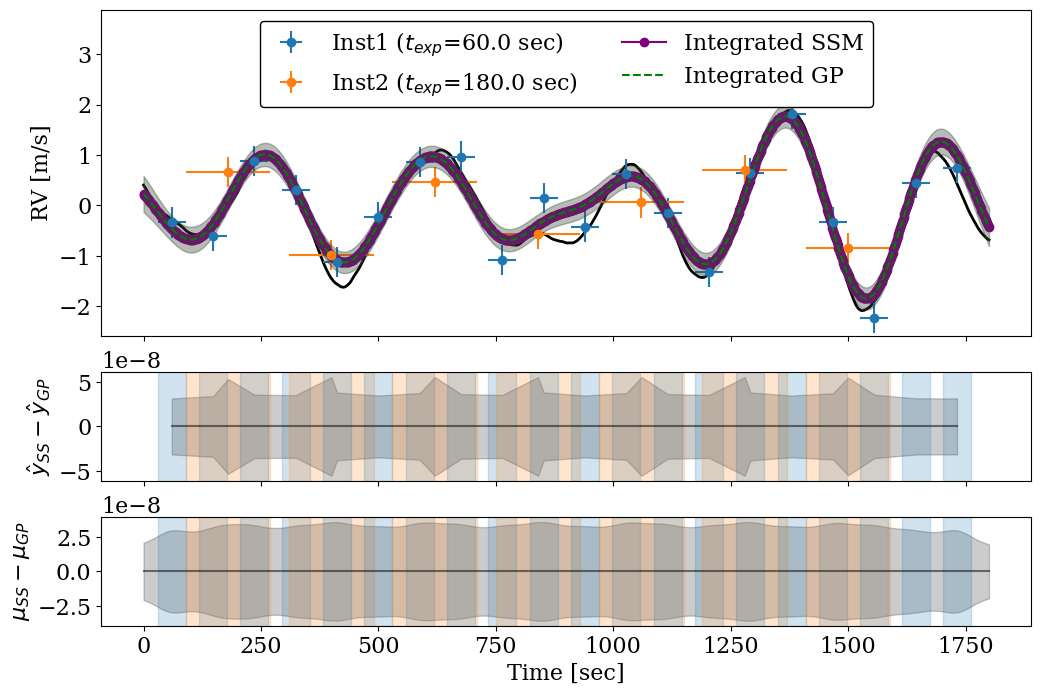

In [92]:
fig, (ax, rax, rrax) = plt.subplots(3,1, figsize=(12, 8), sharex=True, 
                                    gridspec_kw={'height_ratios':[3,1,1]})

css = 'purple'

lines = []
l1, = ax.plot(t_true, y_true, label='True signal', color='k', lw=2)
# lines.append(l1)
# ax.errorbar(tobs.value, y_inst,  yerr=yerr, fmt='o', color='grey')
# l2 = ax.errorbar(t_train, y_train, xerr=texp_train/2, yerr=yerr, fmt='o', 
#                  color='k', label=r'$t_{exp}$=' + f'{texp} sec')
# lines.append(l2)
for instid in range(Ninst):
    inst = (instids==instid)
    l2 = ax.errorbar(t_train[inst], y_train[inst], xerr=texp_train[inst]/2, yerr=yerr,
                 fmt='o', label=f'Inst{instid+1} ($t_{{exp}}$={texp_train[inst][0]} sec)')
    lines.append(l2)

## State space version
# _, = ax.plot(t_train, y_ss, 'o',  color=css,  ls='-', zorder=2)
# ax.fill_between(t_train, y_ss-yerr_ss, y_ss+yerr_ss, zorder=2, color=css, alpha=0.2)
l3, = ax.plot(t_test, mu_ss, 'o-', color=css, label="Integrated SSM", ls='-')
ax.fill_between(t_test, mu_ss-std_ss, mu_ss+std_ss, zorder=2, color=css, alpha=0.2)

## Full GP version
# _, = ax.plot(t_train, y_gp, 'o', color=cgp,   ls='--',)
# ax.fill_between(t_train, y_gp-yerr_gp, y_gp+yerr_gp, color=cgp, alpha=0.2)
l4, = ax.plot(t_test, mu_gp, color=cgp,   ls='--', label="Integrated GP")
ax.fill_between(t_test, mu_gp-std_gp, mu_gp+std_gp, zorder=2, color=cgp, alpha=0.2)

# rax.plot(t_train, y_ss - y_true, color=css, ls='-')
# rax.plot(t_train, y_gp - y_true, color=cgp, ls='--')
# rax.fill_between(t_train, y_ss-yerr_ss - y_true, y_ss+yerr_ss - y_true, ls='-',  color=css, alpha=0.2)
# rax.fill_between(t_train, y_gp-yerr_gp - y_true, y_gp+yerr_gp - y_true, ls='--', color=cgp, alpha=0.2)
rax.plot(t_train, y_ss - y_gp, ls='-', color='k', alpha=0.5)
rax.fill_between(t_train, (y_ss-yerr_ss) - (y_gp-yerr_gp), (y_ss+yerr_ss) - (y_gp+yerr_gp), ls='-', color='k', alpha=0.2)
for n, (t1, t2) in enumerate(zip(tstart, tend)):
    rax.axvspan(t1, t2, color=f'C{instids[n]}', alpha=0.2)
rax.set(ylabel=r'$\hat{y}_{SS}- \hat{y}_{GP}$')

mu_true = f(u.Quantity(t_test/60, 'min'))
# rrax.plot(t_test, mu_gp - mu_true, ls='-', color=cgp, alpha=1)
# rrax.fill_between(t_test, mu_gp-std_gp - mu_true, mu_gp+std_gp - mu_true, ls='-', color=cgp, alpha=0.2)
# rrax.plot(t_test, mu_ss - mu_true, ls='-', color=css, alpha=0.5)
# rrax.fill_between(t_test, mu_ss-std_ss - mu_true, mu_ss+std_ss - mu_true, ls='-', color=css, alpha=0.2)
# rrax.set(ylabel=r'$\mu - \mu_{true}$')

rrax.plot(t_test, mu_ss - mu_gp, ls='-', color='k', alpha=0.5)
rrax.fill_between(t_test, (mu_ss-std_ss) - (mu_gp-std_gp), (mu_ss+std_ss) - (mu_gp+std_gp), ls='-', color='k', alpha=0.2)
for n, (t1, t2) in enumerate(zip(tstart, tend)):
    rrax.axvspan(t1, t2, color=f'C{instids[n]}', alpha=0.2)
rrax.set(ylabel=r'$\mu_{SS}- \mu_{GP}$')

lines.extend([l3, l4])
ax.legend(lines, [l.get_label() for l in lines],
            ncol=2, loc='upper center', framealpha=1, edgecolor='k', 
            # facecolor='#232323' 
            )
ax.set_ylim(f(t).min()-.5, f(t).max()+2)
ax.set(ylabel='RV [m/s]');
# rax.set(ylabel=r'$\hat{y}-\hat{y}_\mathrm{true}$')
rrax.set(xlabel=f'Time [sec]');
# plt.savefig('/Users/rrubenzahl/Desktop/ss_vs_gp_integrated.png', dpi=300, bbox_inches='tight')